In [1]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from utils import networks, util
import copy
from keras import backend as K 
from keras.applications import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout
from keras.models import Model
from keras.callbacks import Callback
from keras import callbacks
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


2.2.4


In [2]:
data_train = pd.read_csv('./fashionmnist/fashion-mnist_train.csv')
data_test = pd.read_csv('./fashionmnist/fashion-mnist_test.csv')
# Read our image
img_rows, img_cols = 75, 75
input_shape = (img_rows, img_cols, 1)

X = np.array(data_train.iloc[:, 1:])
y = to_categorical(np.array(data_train.iloc[:, 0]))

#Test data
X_test = np.array(data_test.iloc[:, 1:])
y_test = to_categorical(np.array(data_test.iloc[:, 0]))

# InceptionV3 needs at least 75,75 input
_, _, _, X_tr_res, X_val_res, X_te_res, y_train, y_val = util.prepare_data(X,y,X_test,75,75)

In [3]:
# Network needs RGB images so we copy data to 3 dimentions

X_tr_res = X_tr_res.reshape(X_tr_res.shape[0], img_rows, img_cols)
X_val_res = X_val_res.reshape(X_val_res.shape[0], img_rows, img_cols)
X_te_res = X_te_res.reshape(X_te_res.shape[0], img_rows, img_cols)

tr_rgb_batch = np.repeat(X_tr_res[..., np.newaxis], 3, -1)
val_rgb_batch = np.repeat(X_val_res[..., np.newaxis], 3, -1)
test_rgb_batch = np.repeat(X_te_res[..., np.newaxis], 3, -1)

In [4]:
batch_size = 256
epochs = 50
num_classes = 10

In [5]:
datagen = ImageDataGenerator(
            shear_range=0.1, # shear_range is for randomly applying shearing transformations
            zoom_range = 0.01, #zoom_range is for randomly zooming inside pictures
            horizontal_flip=True)

In [6]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
callbacks_list = [reduce_lr_loss, early_stopping]

history = model.fit_generator(datagen.flow(tr_rgb_batch, y_train,batch_size=batch_size),
          steps_per_epoch=len(tr_rgb_batch) / 64,
          epochs=epochs,
          verbose=1,
          validation_data=(val_rgb_batch, y_val),
          callbacks=[early_stopping, reduce_lr_loss])
util.save_everything(model,'inception_transfer_50ep', history)

Epoch 1/50
750/750 [==============================] - 172s 229ms/step - loss: 0.2315 - acc: 0.9196 - val_loss: 0.3106 - val_acc: 0.8993
Epoch 2/50
750/750 [==============================] - 154s 206ms/step - loss: 0.1241 - acc: 0.9559 - val_loss: 0.2230 - val_acc: 0.9283
Epoch 3/50
750/750 [==============================] - 155s 206ms/step - loss: 0.0856 - acc: 0.9698 - val_loss: 0.2398 - val_acc: 0.9290
Epoch 4/50
750/750 [==============================] - 155s 206ms/step - loss: 0.0935 - acc: 0.9677 - val_loss: 0.2112 - val_acc: 0.9312
Epoch 5/50
750/750 [==============================] - 154s 206ms/step - loss: 0.0510 - acc: 0.9819 - val_loss: 0.2655 - val_acc: 0.9289
Epoch 6/50
750/750 [==============================] - 155s 206ms/step - loss: 0.0380 - acc: 0.9868 - val_loss: 0.2733 - val_acc: 0.9301
Epoch 7/50
750/750 [==============================] - 155s 207ms/step - loss: 0.0292 - acc: 0.9899 - val_loss: 0.2898 - val_acc: 0.9319
Epoch 8/50
750/750 [============================

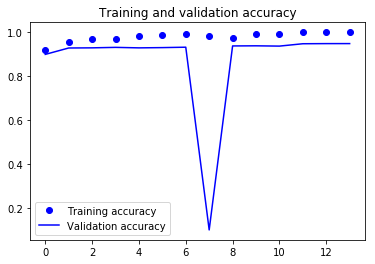

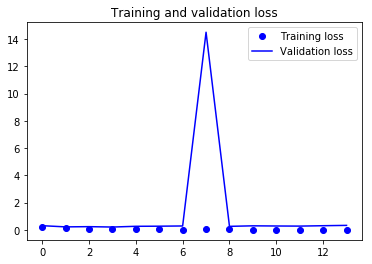

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_r = range(len(accuracy))
plt.plot(epochs_r, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs_r, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_r, loss, 'bo', label='Training loss')
plt.plot(epochs_r, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()